### Name: Md Rafiqul Islam Rabin
### Email: mrabin@central.uh.edu
### PS ID: 1797648


In this notebook, I have adapted *Gustavo*'s [demo code](https://colab.research.google.com/github/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/Sequence%20to%20Sequence%20Models%20%28COSC%206336%29.ipynb) of Sequence to Sequence Models to implement the batch support for encoder and decoder. The task of the model is to map the sequences with repeated and unordered letters to alphabetically-sorted sequences of unique letters, i.e. *ccccaaabb -> abc*. The training and validation dataset are automatically-generated corpus, and the test dataset has been downloaded from [this link](https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/test.txt) shared by *Gustavo*.

The original demo code is not efficient because it does not use batches. Instead, it processes sample by sample without taking advantage of parallelization. The target of this assignment is to optimize the demo code using batch implementation. I will keep the same overall architecture of the demo code, which is a single LSTM layer with one direction on both the encoder and decoder while also using attention.

# **1. Importing packages:**

I have imported all necessary packages first to run my code: **os** for checking if a path exists, **random** for getting a random number and shuffling the train set, **numpy** for getting transposed array and counting non-zeros in a list, **pandas** for reading the test CSV file, **torch** for PyTorch implementation of the model, **accuracy_score** for calculating accuracy, **_pickle** for dumping and loading loss values as a list, **datetime** for getting current time, **pyplot** for drawing plots, **copy** for copying an object in python, and **warnings** for filtering user warnings. We also set manual seed as 1 to **torch** and **random** for reproducing the result.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score
import _pickle as pk
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
random.seed(1)

import copy, warnings
warnings.simplefilter("ignore", UserWarning)

# **2. Config dictionary:**

I have created a dictionary named **config** for configuration handling. I have defined the value of all parameters in this **config** dictionary to avoid the hard-coded value in code. The **num_train** denotes the number of training inputs and the **num_valid** denotes the number of validation inputs. The **pred_maxlen** means how many steps our model will predict given a test input if the end token is not found. Then, I have included the learning rate (**lr**), the momentum (**mt**), the embedding dimension (**emb_dim**), the hidden size of LSTM (**lstm_size**), the linear size of AttentionDecoder (**attn_size**), the dropout probability of model's regularization (**dropout**), the number of epochs (**epoch**), and the batch size (**batch**). Finally, I have also added the path of the test file (**testfile**), the checkpoint for the loss value (**lossfile**) and the encoder-decoder model (**checkpoint**). I will explain the usage of these parameters later while implementing the encoder-decoder model.

In [2]:
config = {
    'num_train': 20000,
    'num_valid': 5000,
    'pred_maxlen': 10,
    
    'lr': 0.001,
    'mt': 0.99,
    'emb_dim': 64,
    'lstm_size': 128,
    'attn_size': 100,
    'dropout': 0.5,
    'batch': 32,
    'epoch': 50,
    
    'testfile': "data/raw/test.txt",
    'lossfile': 'model.loss',
    'checkpoint': "model.pt"
}

# **3. Creating the training and validation set:**

Here, I have used *Gustavo*'s **sorting_letters_dataset** function that takes the **size** as an argument and returns the number of inputs. I have also created 20,000 samples for the training set and 5,000 samples for the validation set. Each sample has 3-10 letters that repeat 1-3 times. The training set is used to update the parameters of the model and the validation set is used to select the best model.

In [3]:
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

train_inp, train_out = sorting_letters_dataset(config['num_train'])
valid_inp, valid_out = sorting_letters_dataset(config['num_valid'])

# **4. Mapping dataset through vocabulary:**

Here, I have used *Gustavo*'s **Vocab** class to handle the dataset. Our dataset contains letters (a-z) and we would like to map those letters to numbers. The source vocabulary (**src_vocab**) contains 27 tokens ($<$pad$>$ token and 26 letters) and the target vocabulary (**tgt_vocab**) contains 29 tokens ($<$pad$>$ token, 26 letters, $<$start$>$ and $<$stop$>$ token). The **map_elems** function maps a single input and **map_many_elems** function maps a list of inputs to numbers from letters. Using these helper functions, I have mapped the entire train and valid dataset. Additionally, I'm also storing the index of $<$pad$>$, $<$start$>$ and $<$stop$>$ token to be used in encoder/decoder and training/evaluation.

In [4]:
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 

src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<start>', '<stop>'] )

def map_elems(elems, mapper):
    return [mapper[elem] for elem in elems]

def map_many_elems(many_elems, mapper):
    return [map_elems(elems, mapper) for elems in many_elems]

train_x = map_many_elems(train_inp, src_vocab.stoi)
train_y = map_many_elems(train_out, tgt_vocab.stoi)
print("Length of the training dataset: {}".format(len(train_x)))

valid_x = map_many_elems(valid_inp, src_vocab.stoi)
valid_y = map_many_elems(valid_out, tgt_vocab.stoi)
print("Length of the validation dataset: {}".format(len(valid_x)))

PAD_IX   = tgt_vocab.stoi['<pad>']
START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']

Length of the training dataset: 20000
Length of the validation dataset: 5000


# **5. Encoder:**

**Architecture of the encoder**: The encoder is implemented with a simple LSTM model with one layer (**num_layers=1** by default) and one direction (**bidirectional=False** by default). Additionally, in the LSTM model, the number of expected features in the input is 64 (**emb_dim**), the number of features in the hidden state is 128 (**lstm_size**), and the input and output tensors are provided as **(batch, seq, feature)** as the **batch_first=True**. The encoder also includes one embedding layer and one dropout layer. In the embedding layer, the size of the dictionary of embeddings is 27 (**src_vocab**), and the size of each embedding vector is 64 (**emb_dim**). In the dropout layer, the probability of the activation of an element to be zeroed is 0.5 (**dropout**), it is only applied during training. This layer randomly sets some of its input to zero, which makes the final trained network more robust and less prone to overfitting.

**Batch processing for encoder**:
In order to support batch processing, I have used the [pad-pack mechanism](https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html). First, I have created a multi-dimensional tensor for containing the batch inputs. The batch inputs may have variable length tokens, but we need the fixed-length inputs for performing embeddings. Therefore, the **pad_sequence** function is used to convert the variable-length sequences to the same length using **padding_value=PAD_IX** for filling with zeros. Then, I have converted the padded sequences to embeddings and have applied the dropout regularization to prevent overfitting. However, the LSTM model wants only the meaningful timesteps of each input. For that, I have packed the padded-embedded sequence using **pack_padded_sequence** function, where we need to provide the length of each batch inputs. We also set **enforce_sorted=False** as we are dealing with unsorted sequences. Now, I have fed the packed data (that only keeps the meaningful timestep according to the lengths tensor) into the LSTM model and stored the output features, hidden state, and cell state from the last layer of the LSTM model. Finally, the **pad_packed_sequence** function is applied to the output features to convert into the padded output format. Note that I have used the **batch_first=True** in all scenarios as the tensor is provided as **(batch, seq, feature)**. Based on the **z_index** the encoder returns the output features as **(batch, seq, lstm_dim)** tensor or the (hidden state, cell state) as **(batch, lstm_dim)** tensor. The major modifications insides the **forward()** are: 1) padding the variable-length sequences to fixed-length sequences that are needed for applying embeddings, 2) packing the padded-embedded sequences as the LSTM model wants the meaningful timestep, and 3) padding the packed output features for making fixed-length.

In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, z_type, dropout=0.5):
        super(Encoder, self).__init__()
        self.z_index = z_type
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, lstm_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, enc_inputs):
        batch_inputs = copy.deepcopy(enc_inputs)
        device = next(self.parameters()).device
        
        x_tensor = [torch.tensor(sample).to(device) for sample in batch_inputs]
        x_pad = pad_sequence(x_tensor, batch_first=True, padding_value=PAD_IX) # (batch, seqlen) 
        x_emb = self.emb(x_pad) # (batch, seqlen, emb_dim) 
        x_emb = self.drop(x_emb)
        
        x_len = [len(sample) for sample in batch_inputs]
        x_pack = pack_padded_sequence(x_emb, x_len, batch_first=True, enforce_sorted=False)
        outs_pack, (h_n, c_n) = self.lstm(x_pack)
        outs, _ = pad_packed_sequence(outs_pack, batch_first=True)
            
        if self.z_index == 1:
            return h_n[0], c_n[0] # (seqlen, batch, lstm_dim)
        else:
            return outs # (batch, seqlen, lstm_dim)

encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_dim'], 
                  lstm_size=config['lstm_size'], 
                  z_type=0)

print(encoder)

Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
)


# **6. Attention Decoder:**

**Architecture of the decoder**: Similar to the encoder, the decoder is implemented with an LSTM cell with one layer and one direction. The attention version that we use for this implementation is Luong's attention, also known as multiplicative attention. The attention-decoder contains one embedding layer, one dropout layer, one LSTM cell, one attention layer, one linear layer. The LSTM cell in decoder has the same dimensions of the LSTM model in the encoder. However, in the embedding layer, the size of the dictionary of embeddings is 29 (**tgt_vocab**) as decoder needs two extra tokens: $<$start$>$ and $<$stop$>$. The attention class concatenates the encoder outputs with decoder states, multiplies by W that maps to the attention dimensions, squashes to the range [-1, 1] using **tanh**, and then multiplies by the scaler v that converts to single scores. After that, the scores are normalized with **softmax** and multiplied with encoder outputs to get the context from the weighted sum. The context is then concatenated with the decoder states and used for predicting the next step. The linear layer applies a linear transformation to the incoming combined data and computes the predicted scores. Finally, the **CrossEntropyLoss** is used to get the loss value that is sent for backpropagation. Also, during prediction, the argmax with softmax is applied to the predicted scores to compute the next token. During training, the teacher forcing mechanism has applied where we set the ground-truth token for calculating the next timestep instead of the previous predicted timestep. However, during evaluation and prediction, we should use the previously predicted timestep for calculating the next timestep.

**Batch processing for decoder**: The **AttentionDecoder** class has to be modified in several areas in order to support batch processing. The major modifications insides the **forward()** function are: 1) Changing the **torch.zeros(1,)** to **torch.zeros(batch_size,)** inside the **init_state()**. 2) Padding the batch targets based on the max length inside the current batch (i.e., **pad_targets()**). 3) Creating the initial input tensor with **$<$start$>$ * batch_size** tokens instead of a single **$<$start$>$** token, as each timestep we expect the decoder to process the batch number of different sequence prediction in parallel and each will start from the **$<$start$>$** token. 4) Similarly, creating the target tensors based on the next token from each sample of batches. 5) Adding **ignore_index=PAD_IX** to the objective function to ignore the padding value in loss calculation, as we have added padding to make fixed-length the sequence prediction will continue till the maxlen. Therefore, the loss of padding value will be ignored. 6) Determining the mask length of each sample of batch inputs to calculate the batch loss. Similarly, during prediction I have made following further changes inside **predict()** function - 7) Adding the **dim=1** inside the argmax function for batch prediction, and transposing the prediction list to get prediction sequence for each input. 8) Removing the extra tokens after end token as the decoder continues till the maxlen for batch processing. I have also created another function called **evaluate()** inside the decoder same as the **predict()** function. The only difference is that the **predict()** does not requires ground-truth and returns only predicted sequence. On the other hand, the **evaluate()** requires ground-truth to compute the loss (i.e. validation loss) and returns both the loss and prediction of batch input. Note that during training and validation the max prediction size is determined by length of ground-truth targets inside each batch, but the prediction size is passed as an argument during prediction as we should not use the information of targets during prediction.

In [6]:
class Attention(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(input_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
        
    def forward(self, dec_hidden, enc_outs):
        # enc_outs -> (batch, seqlen, hidden)
        # dec_hidden -> (batch, hidden)
        
        seqlen = enc_outs.size(1)
        
        repeat_h = dec_hidden.unsqueeze(1)  # make room to repeat on seqlen dim
        repeat_h = repeat_h.repeat(1, seqlen, 1)  # (1, seqlen, hidden)

        concat_h = torch.cat((enc_outs, repeat_h), dim=2) # (1, seqlen, hidden*2)
        
        scores = self.v(torch.tanh(self.W(concat_h))) # (1, seqlen, 1)
        probs = torch.softmax(scores, dim=1)
        
        weighted = enc_outs * probs # (1, seqlen, hidden)
        
        context = torch.sum(weighted, dim=1, keepdim=False) # (1, hidden)
        combined = torch.cat((dec_hidden, context), dim=1)  # (1, hidden*2)
        
        return combined

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, attn_size, dropout=0.5):
        super(AttentionDecoder, self).__init__()
        
        self.lstm_size = lstm_size
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.attn = Attention(lstm_size * 2, attn_size)
        self.clf = nn.Linear(lstm_size * 2, vocab_size)
        
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="none", ignore_index=PAD_IX)
        
    def init_state(self, batch_size, device):
        h_0 = torch.zeros(batch_size, self.lstm_size).to(device)  # (batch, hidden_size)
        c_0 = torch.zeros(batch_size, self.lstm_size).to(device)  # (batch, hidden_size)
        return h_0, c_0
    
    def pad_targets(self, targets):
        maxlen = max([len(target) for target in targets])
        for i in range(len(targets)): 
            targets[i].append(STOP_IX) #added last token
            targets[i].extend([PAD_IX] * (maxlen + 1 - len(targets[i]))) #added pad token
        return targets, maxlen
            
    def forward(self, enc_outs, dec_targets, curr_token, last_token):
        batch_targets = copy.deepcopy(dec_targets)
        device = next(self.parameters()).device
        batch_size = enc_outs.shape[0]
        state = self.init_state(batch_size, device) # (batch, lstm_dim)
        
        batch_targets, maxlen = self.pad_targets(batch_targets)
        
        batch_loss = 0.0
        curr_tokens = [curr_token] * batch_size
        for i in range(maxlen + 1):
            inputs = torch.tensor(curr_tokens).to(device) # (batch)
            
            emb = self.emb(inputs) # (batch, emb_dim)
            emb = self.drop(emb) # (batch, emb_dim)
            
            state = self.lstm(emb, state) # (batch, lstm_dim)
            q_i, _ = state 
            q_i = self.drop(q_i) # (batch, lstm_dim)
            
            combined = self.attn(q_i, enc_outs) # (batch, lstm_dim * 2)
            scores = self.clf(combined) # (batch, tgt_vocab)
            
            next_tokens = [targets[i] for targets in batch_targets]
            targets = torch.tensor(next_tokens).to(device) # (batch)
            batch_loss += self.objective(scores, targets) # (batch)
            
            curr_tokens = next_tokens
        
        maskcount = [np.count_nonzero(targets) for targets in batch_targets]
        maskcount = torch.tensor(maskcount, dtype=torch.float32).to(device)
        batch_loss = (batch_loss/maskcount).sum()
        
        return batch_loss
    
    def predict(self, enc_outs, curr_token, last_token, maxlen):
        device = next(self.parameters()).device
        batch_size = enc_outs.shape[0]
        state = self.init_state(batch_size, device) # (batch, lstm_dim)
        
        batch_preds = []
        curr_tokens = [curr_token] * batch_size
        for i in range(maxlen + 1):
            inputs = torch.tensor(curr_tokens).to(device) # (batch)
            
            emb = self.emb(inputs) # (batch, emb_dim)
            
            state = self.lstm(emb, state) # (batch, lstm_dim)
            q_i, _ = state 
            
            combined = self.attn(q_i, enc_outs) # (batch, lstm_dim * 2)
            scores = self.clf(combined) # (batch, tgt_vocab)
            
            pred_tokens = torch.argmax(torch.softmax(scores, dim=1), dim=1) # (batch)
            curr_tokens = pred_tokens
            batch_preds.append(pred_tokens.tolist())

        batch_preds = np.array(batch_preds).T.tolist()
        for ix, _ in enumerate(batch_preds):
            if last_token in batch_preds[ix]:
                last_token_ix = batch_preds[ix].index(last_token)
                batch_preds[ix] = batch_preds[ix][:last_token_ix]
        return batch_preds
    
    def evaluate(self, enc_outs, dec_targets, curr_token, last_token):
        batch_targets = copy.deepcopy(dec_targets)
        device = next(self.parameters()).device
        batch_size = enc_outs.shape[0]
        state = self.init_state(batch_size, device) # (batch, lstm_dim)
        
        batch_targets, maxlen = self.pad_targets(batch_targets)
        
        batch_preds, batch_loss = [], 0.0
        curr_tokens = [curr_token] * batch_size
        for i in range(maxlen + 1):
            inputs = torch.tensor(curr_tokens).to(device) # (batch)
            
            emb = self.emb(inputs) # (batch, emb_dim)
            
            state = self.lstm(emb, state) # (batch, lstm_dim)
            q_i, _ = state
            
            combined = self.attn(q_i, enc_outs) # (batch, lstm_dim * 2)
            scores = self.clf(combined) # (batch, tgt_vocab)
            
            next_tokens = [targets[i] for targets in batch_targets]
            targets = torch.tensor(next_tokens).to(device) # (batch)
            batch_loss += self.objective(scores, targets) # (batch)
            
            pred_tokens = torch.argmax(torch.softmax(scores, dim=1), dim=1) # (batch)
            curr_tokens = pred_tokens
            batch_preds.append(pred_tokens.tolist())
        
        maskcount = [np.count_nonzero(targets) for targets in batch_targets]
        maskcount = torch.tensor(maskcount, dtype=torch.float32).to(device)
        batch_loss = (batch_loss/maskcount).sum()
        
        batch_preds = np.array(batch_preds).T.tolist()
        for ix, _ in enumerate(batch_preds):
            if last_token in batch_preds[ix]:
                last_token_ix = batch_preds[ix].index(last_token)
                batch_preds[ix] = batch_preds[ix][:last_token_ix]
        
        return batch_preds, batch_loss

decoder = AttentionDecoder(vocab_size=len(tgt_vocab), 
                           emb_dim=config['emb_dim'], 
                           lstm_size=config['lstm_size'], 
                           attn_size=config['attn_size'])

print(decoder)

AttentionDecoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (attn): Attention(
    (W): Linear(in_features=256, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (clf): Linear(in_features=256, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)


# **7. Training loop:**

I have adapted *Niloofar*'s [demo code](https://colab.research.google.com/drive/12a2m4axuWJOWGdynL925zGObcceskW1v#scrollTo=z51kxIBpfhCs) for Sentiment Analysis to build the training loop and to keep track the best model based on the accuracy of the validation set.

The **training_loop()** function handles the training of the model. It first sets the encoder and decoder to the device (CPU or CUDA by checking if CUDA is available). Then, it initializes the SGD (Stochastic Gradient Descent) optimizer for encoder and decoder using the learning rate (=0.001) and the momentum (=0.99) from the config dictionary. For each epoch, it calls the **train()** function to train the model and saves the training loss. After training for an epoch, it calls the **evaluate()** function to get the validation loss and validation accuracy. Based on this validation accuracy, it keeps track of the best model by calling **track_best_model()** function that saves the best model to disk using **torch.save()**. The training will continue until it reaches the maximum epochs. I'm using 50 as the maximum number of epochs to be continued. The model will continue training for 50 epochs and will save the best model according to the validation accuracy. For each epoch, it also displays a log with the current time (see **getCurrentTime()**), epoch, training loss, validation loss, and validation accuracy. After finishing the full training, it dumps the training losses and validation losses to disk using **pickle.dump()**.

The **train()** function first actives the training mode for encoder and decoder by calling **train()**. This is important as layers like dropout has different behavior during train and evaluation. Then, it shuffles the training data (by calling **shuffle()**) before every epoch to prevent any bias of the order of the training. For each batch, it clears the old gradients (by calling **zero_grad()**) that prevents the model to accumulate the gradients from all previous loss. Then, it invokes the **forward()** of the decoder with batch data and completes the forward pass that returns the batch loss. Then, it calls the **loss.backward()** to compute the derivative of the loss and the **optim.step()** to take a step towards the minimum of the loss function. Finally, it sends the training loss to the caller function.

The **evaluate()** function first actives the evaluation mode for encoder and decoder by calling **eval()**. This is important as layers like dropout has different behavior during train and evaluation. Then, it deactivates the autograd (by calling **torch.no_grad()**) to speed up the evaluation and to disable the backpropagation. Then, it invokes the **evaluate()** of the decoder with batch data that returns the batch prediction and batch loss. By calling **map_prediction()**, it converts the numbers to letters using **tgt_vocab.itos** (i.e. [1,2,3] --> ['a','b','c'] --> 'abc']). Finaly, it computs the accurcay between the predictions and actuals, and sends the validation loss  and validation accuracy to the caller function.

In [7]:
def map_prediction(sample_preds):
    sample_preds = [[tgt_vocab.itos[ix] for ix in each_preds] for each_preds in sample_preds]
    sample_preds = [''.join(each_preds) for each_preds in sample_preds]
    return sample_preds

def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)

def evaluate(encoder, decoder, sample_x, sample_y, batch_size):
    encoder.eval()
    decoder.eval()
    
    sample_loss = 0.0
    batch_x, batch_y = [], []
    predictions, actuals = [], []
    
    with torch.no_grad():
        for i in range(len(sample_x)):
            batch_x.append(sample_x[i])
            batch_y.append(sample_y[i])
            
            if len(batch_x) == batch_size or i == len(sample_x) - 1:
                batch_preds, batch_loss = decoder.evaluate(encoder(batch_x), batch_y, START_IX, STOP_IX)
                
                batch_preds = map_prediction(batch_preds)
                predictions.extend(batch_preds)
                batch_y = map_prediction(batch_y)
                actuals.extend(batch_y)
                
                sample_loss += batch_loss.item()
                batch_x, batch_y = [], []
    
    sample_loss = sample_loss / len(sample_x) * 1.0
    
    accuracy = accuracy_score(actuals, predictions)
    return predictions, sample_loss, accuracy

def train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size):
    encoder.train()
    decoder.train()

    train_loss = 0.0
    train_x, train_y = shuffle(train_x, train_y)
    batch_x, batch_y = [], []

    for i in range(len(train_x)):
        batch_x.append(train_x[i])
        batch_y.append(train_y[i])

        if len(batch_x) == batch_size or i == len(train_x) - 1:
            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()
        
            batch_loss = decoder(encoder(batch_x), batch_y, START_IX, STOP_IX)

            batch_loss.backward()
            enc_optim.step()
            dec_optim.step()

            train_loss += batch_loss.item()
            batch_x, batch_y = [], []

    train_loss = train_loss / len(train_x) * 1.0
    
    return encoder, decoder, train_x, train_y, train_loss

In [8]:
def getCurrentTime():
    return str(datetime.datetime.now())

def track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss):
    if best_acc >= valid_acc:
        return best_acc, ''
    state = {
        'encoder': encoder.state_dict(), 
        'decoder': decoder.state_dict(),
        'acc': valid_acc,
        'loss': valid_loss,
        'epoch': epoch
    }
    torch.save(state, config['checkpoint'])
    return valid_acc, ' * '

def training_loop(encoder, decoder, train_x, train_y, epochs, batch_size, print_every=1):
    print("\nTraining with encoder and decoder...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("\nAttaching to device: {}".format(device))
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=config['lr'], momentum=config['mt'])
    dec_optim = optim.SGD(decoder.parameters(), lr=config['lr'], momentum=config['mt'])
    
    best_acc = -1.0
    keep_loss = [[], []] # [[train],[valid]]
    
    for epoch in range(1, epochs+1):
        encoder, decoder, train_x, train_y, train_loss = train(encoder, enc_optim, decoder, dec_optim, train_x, train_y, batch_size)
        _, valid_loss, valid_acc = evaluate(encoder, decoder, valid_x, valid_y, batch_size)
        best_acc, epoch_track = track_best_model(encoder, decoder, epoch, best_acc, valid_acc, valid_loss)

        
        keep_loss[0].append(train_loss)
        keep_loss[1].append(valid_loss)
        
        epoch_msg = '\n[{}] Epoch {:02d}: [TRAIN] Loss: {:.6f}'.format(getCurrentTime(), epoch, train_loss)
        epoch_msg += ' [VAL] Loss: {:.6f}, Acc: {:.6f}'.format(valid_loss, valid_acc)
        print(epoch_msg + epoch_track)
    
    with open(config['lossfile'], 'wb') as lossfile:
        pk.dump(keep_loss, lossfile)
    
    print("\nTraining completed...")
    return True

In [9]:
if not os.path.exists(config['checkpoint']):
    training_loop(encoder, decoder, train_x, train_y, config['epoch'], config['batch'])


Training with encoder and decoder...

Attaching to device: cuda

[2020-04-11 16:26:35.167664] Epoch 01: [TRAIN] Loss: 1.326269 [VAL] Loss: 1.308529, Acc: 0.734600 * 

[2020-04-11 16:26:49.735896] Epoch 02: [TRAIN] Loss: 0.277904 [VAL] Loss: 0.377637, Acc: 0.935000 * 

[2020-04-11 16:27:04.244988] Epoch 03: [TRAIN] Loss: 0.154015 [VAL] Loss: 0.202143, Acc: 0.969000 * 

[2020-04-11 16:27:18.818182] Epoch 04: [TRAIN] Loss: 0.107612 [VAL] Loss: 0.149917, Acc: 0.976800 * 

[2020-04-11 16:27:33.322391] Epoch 05: [TRAIN] Loss: 0.086642 [VAL] Loss: 0.083299, Acc: 0.987800 * 

[2020-04-11 16:27:47.822166] Epoch 06: [TRAIN] Loss: 0.082515 [VAL] Loss: 0.109729, Acc: 0.983000

[2020-04-11 16:28:02.401725] Epoch 07: [TRAIN] Loss: 0.086080 [VAL] Loss: 0.140087, Acc: 0.978600

[2020-04-11 16:28:16.896313] Epoch 08: [TRAIN] Loss: 0.074891 [VAL] Loss: 0.065171, Acc: 0.991400 * 

[2020-04-11 16:28:31.468322] Epoch 09: [TRAIN] Loss: 0.063610 [VAL] Loss: 0.054420, Acc: 0.992800 * 

[2020-04-11 16:28:45.9

# **8. Loading the best model:**

During training, the best model has been saved to disk using **torch.save()** at the checkpoint. If the checkpoint is available, this code will skip the training loop. Otherwise, it will continue the training and will save the best model to disk at the checkpoint. The **load_best_model()** function loads the encoder and decoder from the checkpoint using **torch.load()**. It first initializes the encoder and decoder objects and loads the model's parameter using **load_state_dict**. The training losses and validation losses are also saved using **pickle.dump()** to disk after training and have been loaded from disk using **pickle.load()**.

In [10]:
def load_best_model():
    encoder = Encoder(vocab_size=len(src_vocab), 
                  emb_dim=config['emb_dim'], 
                  lstm_size=config['lstm_size'], 
                  z_type=0)
    decoder = AttentionDecoder(vocab_size=len(tgt_vocab), 
                               emb_dim=config['emb_dim'], 
                               lstm_size=config['lstm_size'], 
                               attn_size=config['attn_size'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = torch.load(config['checkpoint'], map_location=device)
    encoder.load_state_dict(state['encoder'])
    decoder.load_state_dict(state['decoder'])
    state = {'acc': state['acc'], 'loss': state['loss'], 'epoch': state['epoch']}
    return encoder, decoder, state

keep_loss = [[], []] # [[train],[valid]]
with open(config['lossfile'], 'rb') as lossfile:
    keep_loss = pk.load(lossfile)
encoder, decoder, state = load_best_model()
print('Retrieving best model from epoch {} with [DEV] loss {:.6f} and accuracy {:.6f}.'.format(state['epoch'], state['loss'], state['acc'])) 

Retrieving best model from epoch 46 with [DEV] loss 0.010966 and accuracy 0.999200.


# **9. Learning curve for training and validation losses:**

Here, I'm displaying the training and validation losses in a single plot (x-axis is the epochs, and the y-axis is the cross-entropy loss). The blue line represents the training losses and the green line represents the validation losses. Initially, both the training and validation losses are very high (up to 4 epochs) and then it decreases significantly over epochs. However, validation losses are not always lower than training losses. The plot (also see the log of training loop) shows that the validation loss is higher than training loss in most cases up to 7 epochs. Then the training and validation losses decrease with a minimal gap between them up to 32 epochs. After that, the validation losses become consistently smaller than the training losses up to 50 epochs. The plot also demonstrates that the validation losses decrease to a point of stability at the end and maintains a small gap with the training losses. Therefore, the learning curve shows a good fit. Note that I'm attaching an additional file ('model.loss') in my submission to plot this learning curve.

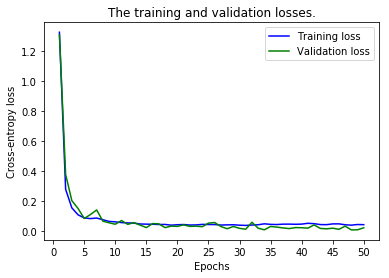

In [11]:
epochs = [i for i in range(1, len(keep_loss[0])+1)]
plt.plot(epochs, keep_loss[0], 'b', label="Training loss")
plt.plot(epochs, keep_loss[1], 'g', label="Validation loss")
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.xticks(np.arange(0,config['epoch']+1,5))
plt.ylabel('Cross-entropy loss')
plt.title('The training and validation losses.')
plt.show()

# **10. Loading the test set:**

Here, I have read the test dataset and mapped the test dataset to numbers from letters using vocabulary helper functions mentioned in section 4. The test dataset contains 5,000 test inputs.

In [12]:
test_data = pd.read_csv(config['testfile'], delimiter='\t', header=None, usecols=[0,1])
test_inp, test_out = test_data[0], test_data[1]  

test_x = map_many_elems(test_inp, src_vocab.stoi)
test_y = map_many_elems(test_out, tgt_vocab.stoi)

print("Length of the test dataset: {}".format(len(test_x)))

Length of the test dataset: 5000


# **11. Result on the test set:**

Here, I'm displaying the result on the test set of my best model according to the accuracy of the validation set. I have measured the performance of my model using accuracy for the exact matches, i.e. if the truth label is 'abcd' and model predicts 'abcdd', then still it is a wrong prediction. The best model has been found at epoch 46 with the validation accuracy of **99.92%**. The accuracy on the test set is **97.74%** for pred_maxlen=10 and **99.60%** for pred_maxlen=20.

In [13]:
def predict(encoder, decoder, sample_x, batch_size, pred_size):
    encoder.eval()
    decoder.eval()
    
    batch_x = []
    predictions = []
    
    with torch.no_grad():
        for i in range(len(sample_x)):
            batch_x.append(sample_x[i])
            
            if len(batch_x) == batch_size or i == len(sample_x) - 1:
                batch_preds = decoder.predict(encoder(batch_x), START_IX, STOP_IX, pred_size)
                batch_preds = map_prediction(batch_preds)
                predictions.extend(batch_preds)
                batch_x = []
            
    return predictions

def getAccuracyScore(encoder, decoder, sample_x, sample_out, batch_size, pred_size):
    predictions = predict(encoder, decoder, sample_x, batch_size, pred_size)
    groundtruth = [''.join(str_y) for str_y in sample_out]
    acc = accuracy_score(groundtruth, predictions)
    return acc

config['pred_maxlen'] = 10
test_acc = getAccuracyScore(encoder, decoder, test_x, test_out, config['batch'], config['pred_maxlen']) * 100
print('Accuracy on the test set (max prediction size = {}) = {:.2f}%'.format(config['pred_maxlen'], test_acc))

config['pred_maxlen'] = 20
test_acc = getAccuracyScore(encoder, decoder, test_x, test_out, config['batch'], config['pred_maxlen']) * 100
print('Accuracy on the test set (max prediction size = {}) = {:.2f}%'.format(config['pred_maxlen'], test_acc))

Accuracy on the test set (max prediction size = 10) = 97.74%
Accuracy on the test set (max prediction size = 20) = 99.60%


# **12. Analysis of results:**

In this section, I will detail comparison of different models according to the following aspects:
<ol>
  <li> Using different epoch (5 vs 50). </li>
  <li> Using batch implementation vs Not using batch implementation. </li>
  <li> Using attention mechanism vs Not using attention mechanism. </li>
</ol>


| Batch?| Attention?| Epoch | Val Accuracy | Test Accuracy |
| ---   | ---       | ---   | ---          | ---           |
| No    | No        | 5     | 98.20        | 86.70         |
| No    | Yes       | 5     | 98.66        | 90.16         |
| No    | No        | 50    | 99.78        | 91.84         |
| No    | Yes       | 50    | 99.96        | 92.54         |
| Yes   | No        | 5     | 97.58        | 90.24         |
| Yes   | Yes       | 5     | 98.78        | 95.26         |
| Yes   | No        | 50    | 99.98        | 97.80         |
| Yes   | Yes       | 50    | 99.92        | 97.74         |

The above table shows the result for the batch implementation (batch=32), attention mechanism (attn_size=100) and the number of epochs (epoch=50). Note that I have conducted this analysis using max prediction size = 10 for the test dataset (same as the demo code). Later, I will show another observation with different prediction sizes.

The observations are -
<ol>
  <li> Epoch: Running the model with 50 epochs increases the accuracy on the validation set and test set in all scenarios compared to the 5 epochs. If the model does not use the attention, the accuracy in the test set improves by 5% for 50 epochs. If the model uses attention, the accuracy in the test set improves by 2% for 50 epochs. On the other hand, the accuracy in the validation set improves by 1% approximately for 50 epochs.
  <li> Batch: Running the model with batch implementation increases the accuracy on the test approximately by 5% in all scenarios. However, there is no unique pattern in the validation accuracy and the change is below 1% as well.
  <li> Attention: Running the model with attention mechanism increases the accuracy on the validation set and test set in most of the scenarios except for batch implementation with 50 epochs. Using batch implementation and 50 epochs, the model without attention mechanism converges to the better performance than the model with attention mechanism, however, the change is only 0.06% for both the validation and test dataset.
</ol>

**More complex dataset:**

To study the attention mechanism, I have run an additional experiment (epoch=50, batch=32, pred_maxlen=10) with more complex and different training and validation set, and have compared the result with the corresponding non-attention mechanism. To generate a more complex and different dataset, I have increased the range of repeated letters from 1-3 to 5-10 and also changed the seed value from 1 to 42. It impacts both the training and validation dataset but keeps the number of total examples the same as before. The results are given below -

| Attention? | Seed  | Range | Val Accuracy | Test Accuracy |
| ---        | ---   | ---   | ---          | ---           |
| No         | 42    |  1-3  | 99.94        | 27.46         |
| Yes        | 42    |  5-10 | 99.76        | 76.96         |

Based on the result of the above table, using a more complex and different dataset, we can clearly see that the attention mechanism outperforms the non-attention mechanism by 49.5% on the test dataset. This indicates that the non-attention mechanism may perform better under certain conditions but the attention mechanism performs significantly better in more complex scenarios. 

**Different prediction sizes:**

It has been said by *Gustavo* that the test dataset is generated in the same manner as the training/validation data, but with intentionally longer input sentences. Therefore, I have conducted an additional analysis (epoch=50, batch=32) with different prediction sizes for the test dataset. Note that the prediction size has no effect on the train and validation dataset as the prediction size is determined by targets inside the batch. The results are given below -

|Attention?| Prediction Size | Test Accuracy |
| ---      | ---   | ---    |
| No       | 10    | 97.80  |
| No       | 20    | 99.70  |
| Yes      | 10    | 97.74  |
| Yes      | 20    | 99.60  |


The result of the above table shows that the accuracy on the test dataset increased by 2% using longer prediction size (20 instead of 10). Note that I'm attaching an additional folder ('Analysis') in my submission with different experimental files.

## References:


<ol>
    <li> https://pytorch.org/docs/stable/nn.html </li>
    <li> https://colab.research.google.com/github/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/Sequence%20to%20Sequence%20Models%20(COSC%206336).ipynb </li>
    <li> https://colab.research.google.com/drive/12a2m4axuWJOWGdynL925zGObcceskW1v </li>
    <li> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html </li>
    <li> https://matplotlib.org/tutorials/introductory/pyplot.html </li>
    <li> https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html </li>
    <li> https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html </li>
</ol>